In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
def f(x):
    return 3*x**3 - 4*x + 5

In [3]:
f(3.2)

90.50400000000003

In [4]:
xs = np.arange(-10,10, 0.25)

In [5]:
ys = f(xs)

In [6]:
ys

array([-2.95500000e+03, -2.73657812e+03, -2.52912500e+03, -2.33235938e+03,
       -2.14600000e+03, -1.96976562e+03, -1.80337500e+03, -1.64654688e+03,
       -1.49900000e+03, -1.36045312e+03, -1.23062500e+03, -1.10923438e+03,
       -9.96000000e+02, -8.90640625e+02, -7.92875000e+02, -7.02421875e+02,
       -6.19000000e+02, -5.42328125e+02, -4.72125000e+02, -4.08109375e+02,
       -3.50000000e+02, -2.97515625e+02, -2.50375000e+02, -2.08296875e+02,
       -1.71000000e+02, -1.38203125e+02, -1.09625000e+02, -8.49843750e+01,
       -6.40000000e+01, -4.63906250e+01, -3.18750000e+01, -2.01718750e+01,
       -1.10000000e+01, -4.07812500e+00,  8.75000000e-01,  4.14062500e+00,
        6.00000000e+00,  6.73437500e+00,  6.62500000e+00,  5.95312500e+00,
        5.00000000e+00,  4.04687500e+00,  3.37500000e+00,  3.26562500e+00,
        4.00000000e+00,  5.85937500e+00,  9.12500000e+00,  1.40781250e+01,
        2.10000000e+01,  3.01718750e+01,  4.18750000e+01,  5.63906250e+01,
        7.40000000e+01,  

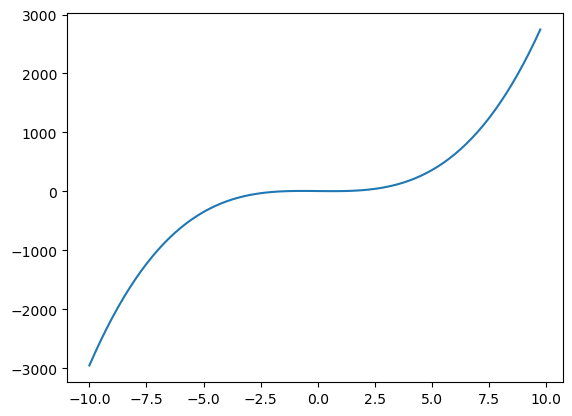

In [7]:
plt.plot(xs, ys)

In [8]:
h = 1e-3
x = 3.2
(f(x+h) - f(x))/h

88.18880299998

In [9]:
a = 2.2
b = 3.1
c = 4.0
d = a*b + c
d

10.82

In [10]:
h = 1e-4
a = 2.2
b = -3.1
c = 4.0
d1 = a*b + c
a+=h
d2 = a*b + c
print((d2-d1)/h)

-3.0999999999981043


In [11]:
h = 1e-4
a = 2.2
b = -3.1
c = 4.0
d1 = a*b + c
b+=h
d2 = a*b + c
print((d2-d1)/h)

2.200000000005531


In [12]:
h = 1e-4
a = 2.2
b = -3.1
c = 4.0
d1 = a*b + c
c+=h
d2 = a*b + c
print((d2-d1)/h)

0.9999999999976694


In [13]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = np.tanh(x)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [14]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
    # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [15]:
#inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias
b = Value(6.8813735870195432, label = 'b')
#calc
x1w1 = x1*w1; x1w1.label = 'x1 * w1'
x2w2 = x2*w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2+b; n.label = 'n'
o = n.tanh(); o.label = 'o'

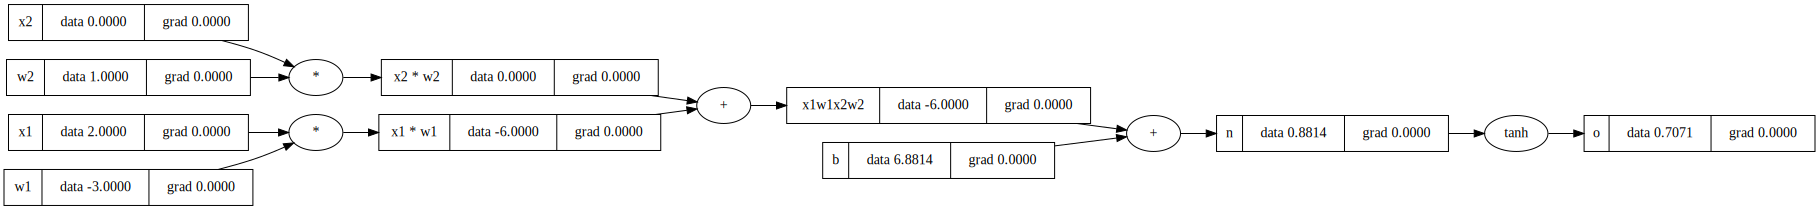

In [16]:
draw_dot(o)

In [17]:
o.backward()

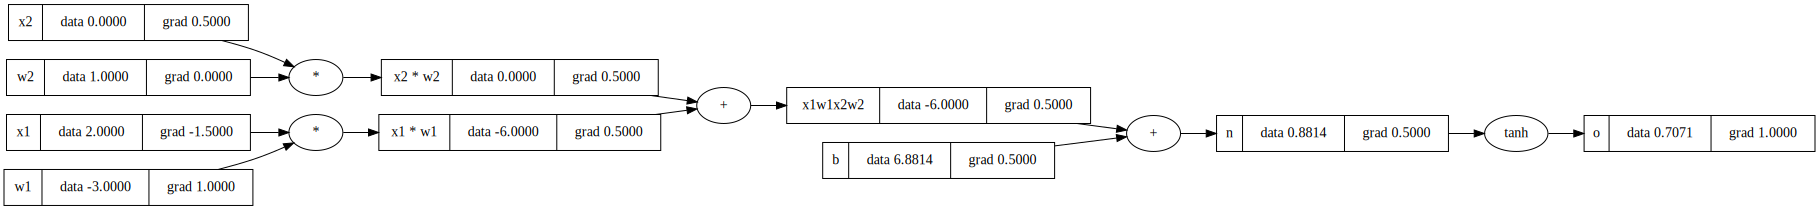

In [18]:
draw_dot(o)

In [19]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [20]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [21]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.7355792575516041)

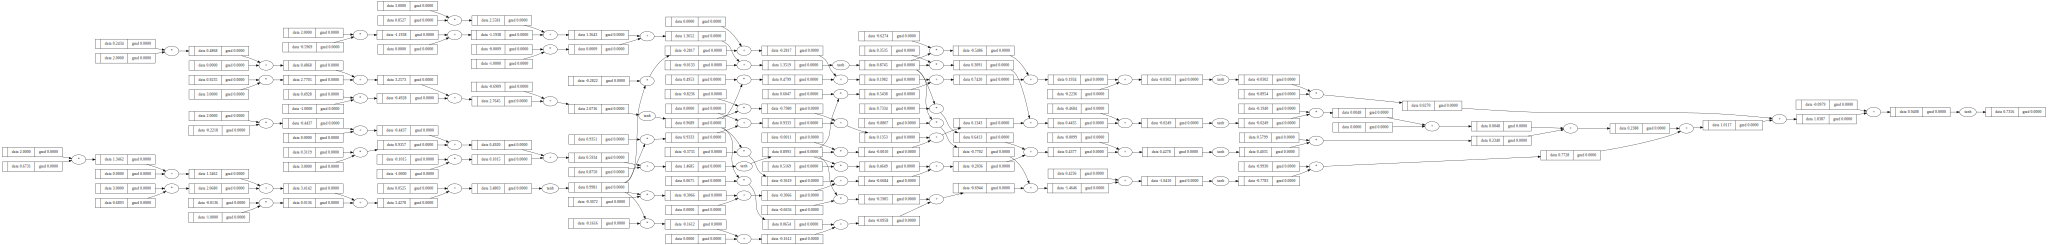

In [22]:
draw_dot(n(x))

In [23]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [24]:
y_pred = [n(x) for x in xs]

In [25]:
y_pred

[Value(data=0.7355792575516041),
 Value(data=-0.8421004305743357),
 Value(data=0.5034785909436366),
 Value(data=0.502810670179205)]

In [26]:
loss = [(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)]
# loss = 

In [27]:
for k in range(5):
  
  # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
        loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 2.602495706175285
1 8.0
2 8.0
3 8.0
4 8.0


In [28]:
ypred

[Value(data=1.0), Value(data=1.0), Value(data=1.0), Value(data=1.0)]